In [1]:
import tensorflow as tf
import tensorflow.feature_column as fc 

import os
import sys
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

#tf.enable_eager_execution()
root_logdir = "./tf_logs"

# For output stability across multiple runs of the notebook
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print(sys.executable)

def shuffle_batch(X, batch_size):
    # Shuffle the indices
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    
    # Split the index array into the number of batches
    # Get the list of indexs per batch
    # and yield the values when asked
    for batch_idxs in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idxs]
        yield X_batch

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tf.__version__

/Users/Work/anaconda3/envs/condaflow/bin/python


'1.13.1'

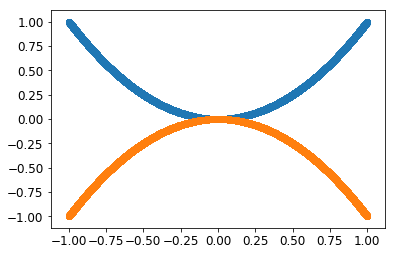

In [2]:
# Funcs to generate data
def y(x,sign=1):
    return x*x

# Data ranging from x = -0.5 to 0.5
def sample_data(n=10000, scale=100):
    data1 = []
    data2 = []
    
    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = y(x[i])
        y2i = -yi
        data1.append([x[i], yi])
        data2.append([x[i], y2i])
        
    return np.float32(np.array(data1)), np.float32(np.array(data2))

nSamples = 20000
X1, X2 = sample_data(n=nSamples,scale=2)
train_data = np.concatenate([X1,X2],axis=1)
plt.scatter(X1[:,0], X1[:,1])
# plt.show()
plt.scatter(X2[:,0], X2[:,1])

In [3]:
from model import RoboGAN

reset_graph()

sess = tf.Session()

nDimX = X1.shape[1]
nDimY = X2.shape[1]

GAN = RoboGAN(nDimX, nDimY)

G = GAN.G
D_Y = GAN.D_Y
F = GAN.F
D_X = GAN.D_X

# Getting placeholders
X = GAN.X
Y = GAN.Y

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
from train import train_step

losses, gradients, trainers, summary_op = train_step(GAN)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [5]:
# Unpacking losses and gradients from training step output
G_loss, F_loss, D_Y_loss, D_X_loss = losses
G_gradients, F_gradients, D_Y_gradients, D_X_gradients = gradients
train_G, train_F, train_D_Y, train_D_X = trainers

## Running the training via a tensorflow session
> Generators will be trained first

In [6]:
sess =  tf.Session()
sess.run(tf.global_variables_initializer())

# Delete exisiting events file
for file in os.listdir(root_logdir):
    os.remove(root_logdir+"/"+file)

train_writer = tf.summary.FileWriter(root_logdir, tf.get_default_graph())

start_time = time.time()
batch_size = 100
n_batches = nSamples / batch_size

for epoch in range(10):
    for batch_index, batch in enumerate(shuffle_batch(train_data, batch_size)):
        X_batch = batch[:,:nDimX]
        Y_batch = batch[:,nDimX:]
        
        
        # Training Generators G and F first w/ cycle consistency
        Gloss, Floss, _,_ = sess.run([G_loss, F_loss, train_G, train_F],
                                     feed_dict={X:X_batch, Y:Y_batch})
        
        # Optimizing Discriminators D_X and D_Y
        D_Xloss, D_Yloss, _,_, summary = sess.run([D_X_loss, D_Y_loss, train_D_X, train_D_Y, summary_op],
                                         feed_dict={X: X_batch, Y: Y_batch})
        
        step = epoch * n_batches + batch_index 
        if step % 100 == 0:
            train_writer.add_summary(summary, step)
#         train_writer.flush()
    
    print("Epoch {}: GLoss:{:.4f}, FLoss:{:.4f}, DXLoss:{:.4f}, DYLoss:{:.4f}".format(epoch,Gloss,Floss,D_Xloss,D_Yloss))

print("Runtime: {:.3f}s".format(time.time()-start_time))
train_writer.close()

Epoch 0: GLoss:2.6406, FLoss:2.5063, DXLoss:0.6550, DYLoss:0.6464
Epoch 1: GLoss:1.7211, FLoss:1.6871, DXLoss:0.6696, DYLoss:0.6655
Epoch 2: GLoss:1.2977, FLoss:1.3634, DXLoss:0.6825, DYLoss:0.6830
Epoch 3: GLoss:1.2100, FLoss:1.2530, DXLoss:0.6682, DYLoss:0.6787
Epoch 4: GLoss:1.0716, FLoss:1.1315, DXLoss:0.6639, DYLoss:0.6783
Epoch 5: GLoss:1.0676, FLoss:1.0612, DXLoss:0.6521, DYLoss:0.6750
Epoch 6: GLoss:1.0280, FLoss:1.0726, DXLoss:0.6738, DYLoss:0.6876
Epoch 7: GLoss:0.9593, FLoss:1.0100, DXLoss:0.6731, DYLoss:0.6913
Epoch 8: GLoss:0.9891, FLoss:1.0318, DXLoss:0.6711, DYLoss:0.6916
Epoch 9: GLoss:0.9597, FLoss:0.9931, DXLoss:0.6805, DYLoss:0.6900
Runtime: 5.204s


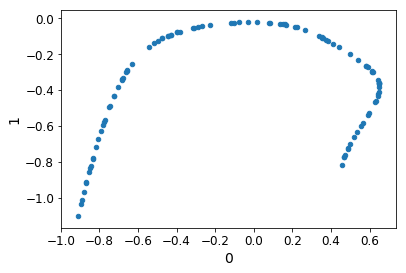

In [12]:
a=sess.run([G(X)], feed_dict={X: X1[:100]})
temp=pd.DataFrame(a[0])
temp.plot.scatter(x=0, y=1)

In [ ]:
b=sess.run([fake_X], feed_dict={Y:X2[:100]})
temp2=pd.DataFrame(b[0])
temp2.plot.scatter(x=0, y=1)

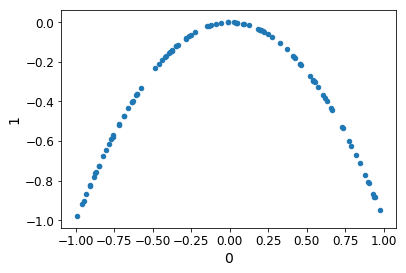

In [41]:
pd.DataFrame(X2[:100]).plot.scatter(x=0,y=1)

In [66]:
train_writer.get_logdir()

'./tf_logs'

In [79]:
tf.summary

<module 'tensorflow._api.v1.summary' from '/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/_api/v1/summary/__init__.py'>

In [92]:
n_batches

200.0

In [1]:
a=[1,2,3]
b,c,d = a

In [2]:
c

2